# Compute Classifier Metrics

Author: Jess Ewald

The classification pipeline now outputs the probability of the positive class for each cell profile, along with the labels and classifier info. This allows us to compute any metric of interest. Here, we compute possible metrics of interest:

- AUC-ROC
- macro-averaged F1 score
- balanced accuracy

And possible AUBPRC, where the positive class is defined as the less abundant one. 

In [1]:
# imports
import polars as pl
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import os
import collections
import plotnine as plotnine

from importlib import reload
import displayImages as di
reload(di)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# paths

res_b7 = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/results/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect"
res_b8 = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/results/2024_02_06_Batch_8/profiles_tcdropped_filtered_var_mad_outlier_featselect"
metrics_dir = "/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/B7B8_1percent"
pm_dir = "/dgx1nas1/storage/data/jess/varchamp/platemaps"

## Compute classifier metrics

In [3]:
# read in bb classifier info
info_b7 = pl.read_csv(f"{res_b7}/classifier_info.csv")
info_b7 = info_b7.with_columns(
    (pl.col("trainsize_1")/(pl.col("trainsize_0") + pl.col("trainsize_1"))).alias("train_prob_1"),
    (pl.col("testsize_1")/(pl.col("testsize_0") + pl.col("testsize_1"))).alias("test_prob_1"),
)

info_b8 = pl.read_csv(f"{res_b8}/classifier_info.csv")
info_b8 = info_b8.with_columns(
    (pl.col("trainsize_1")/(pl.col("trainsize_0") + pl.col("trainsize_1"))).alias("train_prob_1"),
    (pl.col("testsize_1")/(pl.col("testsize_0") + pl.col("testsize_1"))).alias("test_prob_1"),
)

info = pl.concat([info_b7, info_b8])

In [ ]:
# classifier predictions
preds_b8 = pl.scan_parquet(f"{res_b8}/predictions.parquet")
preds_b8 = preds_b8.with_columns(
    pl.lit("batch8").alias("Batch")
).collect()

preds_b7 = pl.scan_parquet(f"{res_b7}/predictions.parquet")
preds_b7 = preds_b7.with_columns(
    pl.lit("batch7").alias("Batch")
).collect()


preds = pl.concat([preds_b7, preds_b8]).with_columns(
    pl.concat_str([pl.col("Classifier_ID"),
                   pl.col("Metadata_Protein"),
                   pl.col("Batch")],
                   separator="_").alias("Full_Classifier_ID")
)

In [ ]:
# Define a function to compute metrics for each group
def compute_aubprc(auprc, prior):
    return (auprc*(1-prior))/((auprc*(1-prior)) + ((1-auprc)*prior))

def compute_metrics(group):
    y_true = group["Label"].to_numpy()
    y_prob = group["Prediction"].to_numpy()
    y_pred = (y_prob > 0.5).astype(int)
    prior = sum(y_true == 1)/len(y_true)
    
    class_ID = group["Classifier_ID"].unique()[0]

    # Compute AUROC
    auroc = roc_auc_score(y_true, y_prob)

    # Compute AUPRC
    auprc = average_precision_score(y_true, y_prob)
    aubprc = compute_aubprc(auprc, prior)

    # Compute macro-averaged F1 score
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    # Compute sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Compute balanced accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)

    return {
        "AUROC": auroc,
        "AUPRC": auprc,
        "AUBPRC": aubprc,
        "Macro_F1": macro_f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Balanced_Accuracy": balanced_acc,
        "Classifier_ID": class_ID
    }


In [ ]:
# Initialize an empty list to store the results
results = []
classIDs = preds.select("Full_Classifier_ID").to_series().unique().to_list()

# Group by Classifier_ID and compute metrics for each group
for id in tqdm(classIDs):
    metrics = compute_metrics(preds.filter(pl.col("Full_Classifier_ID") == id))
    metrics["Full_Classifier_ID"] = id
    results.append(metrics)

# Convert the results to a Polars DataFrame
metrics_df = pl.DataFrame(results)

# Add classifier info and save
metrics_df = metrics_df.join(info, on="Classifier_ID")
metrics_df = metrics_df.with_columns(
    (pl.max_horizontal(["trainsize_0", "trainsize_1"])/pl.min_horizontal(["trainsize_0", "trainsize_1"])).alias("Training_imbalance"),
    (pl.max_horizontal(["testsize_0", "testsize_1"])/pl.min_horizontal(["testsize_0", "testsize_1"])).alias("Testing_imbalance")
)
metrics_df.write_csv(f"{metrics_dir}/metrics.csv")

100%|██████████| 15624/15624 [09:33<00:00, 27.23it/s]


In [4]:
metrics_df = pl.read_csv(f"{metrics_dir}/metrics.csv")

<Figure size 1000x800 with 0 Axes>

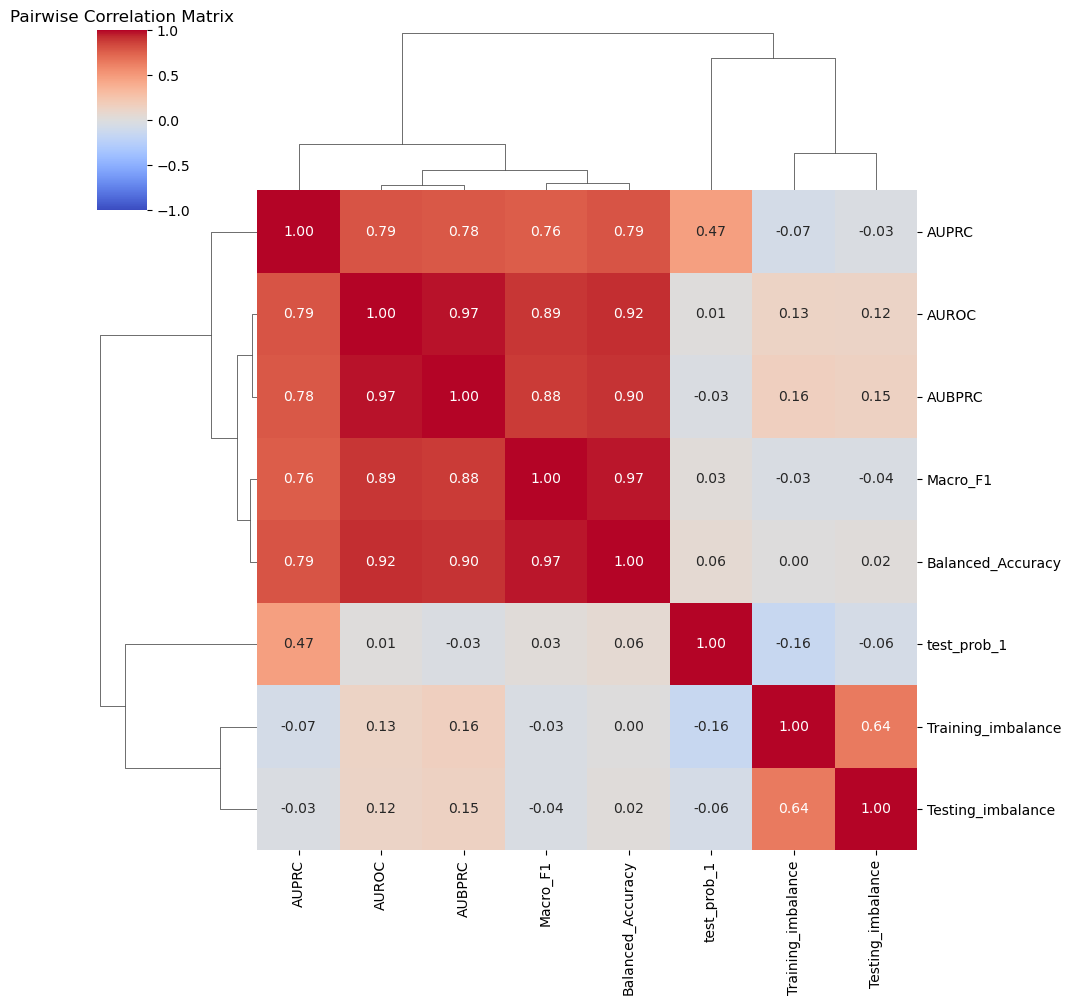

In [5]:
# Analyze pairwise correlation between metrics and test set imbalance
metrics_corr = metrics_df.select([
    'AUROC',
    'AUPRC',
    'AUBPRC',
    'Macro_F1',
    'Balanced_Accuracy',
    'test_prob_1',
    'Training_imbalance',
    'Testing_imbalance'
]).to_pandas().corr()

plt.figure(figsize=(10, 8))
sns.clustermap(metrics_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Pairwise Correlation Matrix")
plt.show()

All metrics are correlated with training imbalance and testing imbalance. The correlation is higher for the training imbalance. 

We do use the "scale_pos_weight" parameter, which is supposed to tell XGBoost to adjust it's weighting of the classes so that the majority class doesn't dominate the training. It's possible that this doesn't completely work and that this positive correlation is still indicative of the dominant class. 

However, I think that it's a different explanation: the single-cell features themselves are correlated with cell count simply based how increased cell density squishes cells, which greatly impacts morphology. Sometimes cell count is an inherently interesting phenomena (ie. toxicity impacts cell viability), however in our experimental set up, the cell count is primarily related to transfection efficiency, which is completely randomly distributed across different genetic perturbations. Therefore, it is a strong, biologically meaningless pattern that is consistent across both technical and biological replicates of each perturbation, making it a nasty confounding factor. Further, it is NOT controlled for by our CTRL-CTRL null because these compare two of the same perturbation and therefore they have the same transfection efficiency. The CTRL-CTRL classifiers are, on average, far more balanced than the WT-VAR classifiers.

One way to control: filter out classifiers that are very imbalanced (define cut-offs based on CTRL-CTRL balances) and only make inferences on the balanced ones. This is not ideal because it will involve throwing out WT-VAR pairs.

What would each cell look like if it wasn't squished?

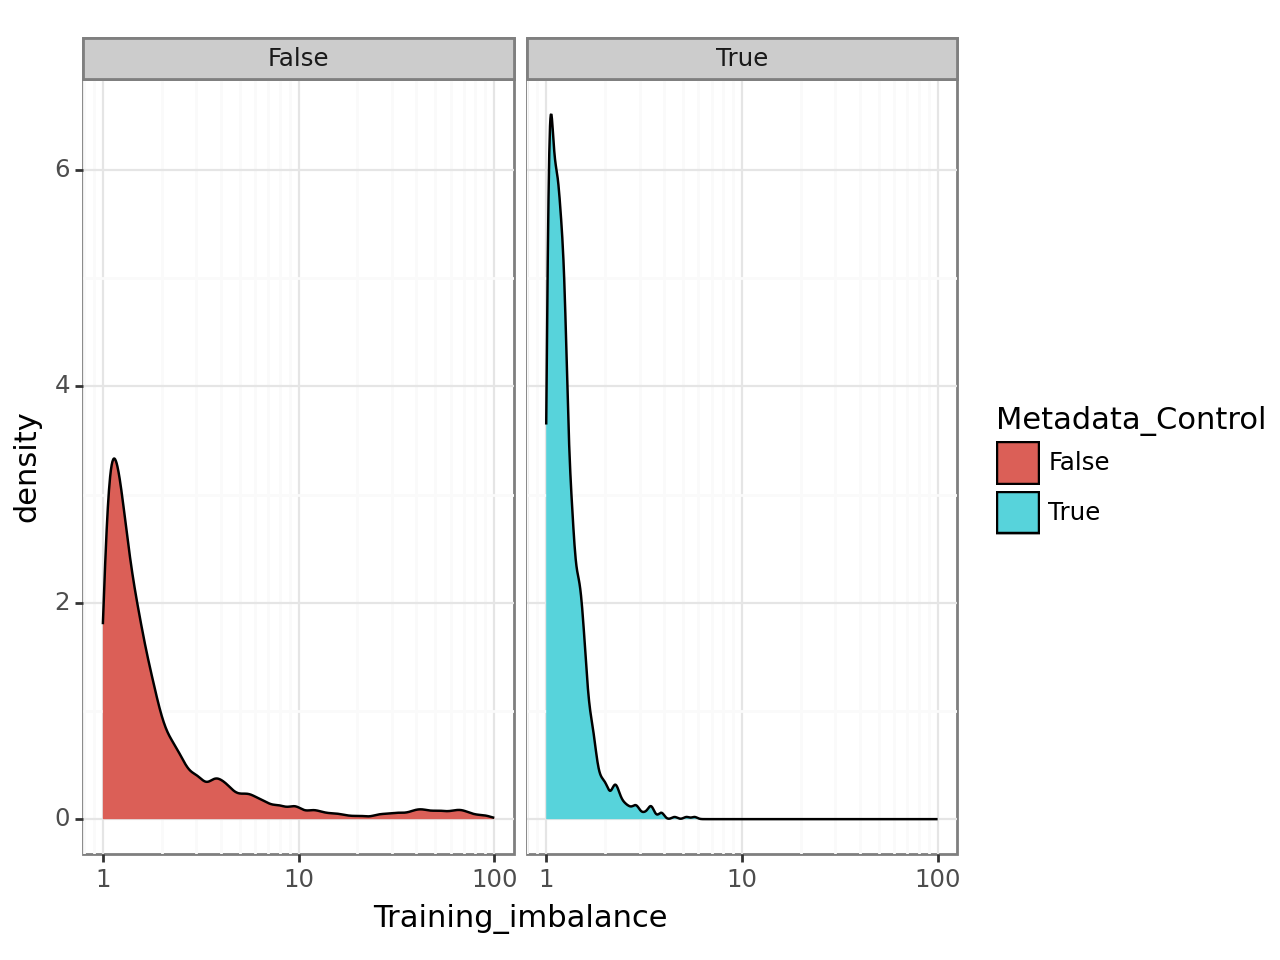

<Figure Size: (640 x 480)>

In [ ]:
from plotnine import ggplot, aes, facet_wrap, scale_x_log10, theme_bw, geom_density

(ggplot(metrics_df, aes(x="Training_imbalance", fill="Metadata_Control"))
 + geom_density()
 + facet_wrap("Metadata_Control")
 + scale_x_log10()
 + theme_bw())

# This plot shows that in the training data, the controls (blue) are far more balanced than the WT-VAR (pink).
# To really prove that this is actual impact of density on features and not simply training class imbalance, I could downsample before training
# If the relationships hold, then we should still see the correlation between well cell count and classifier metrics.

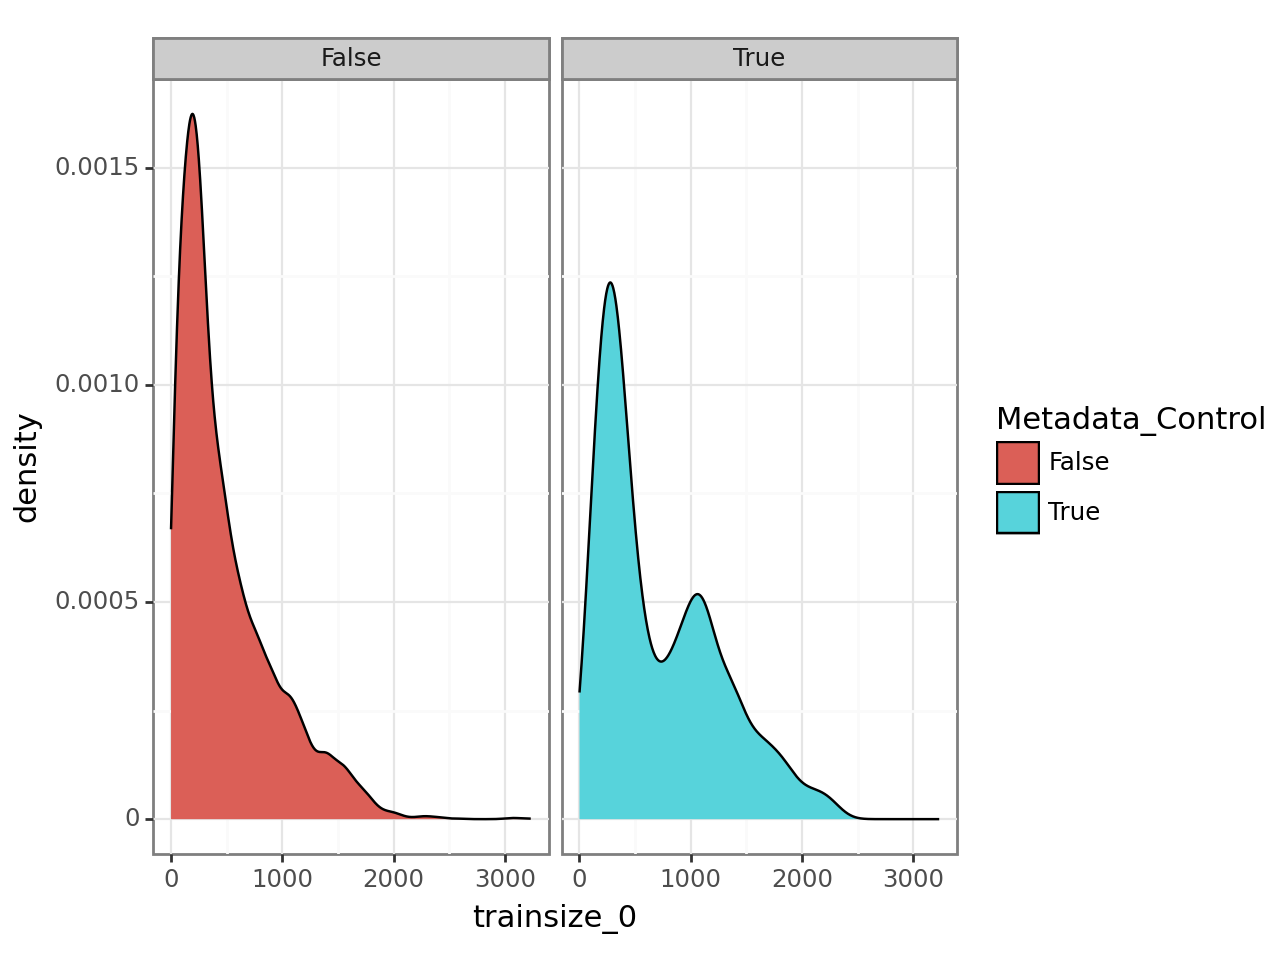

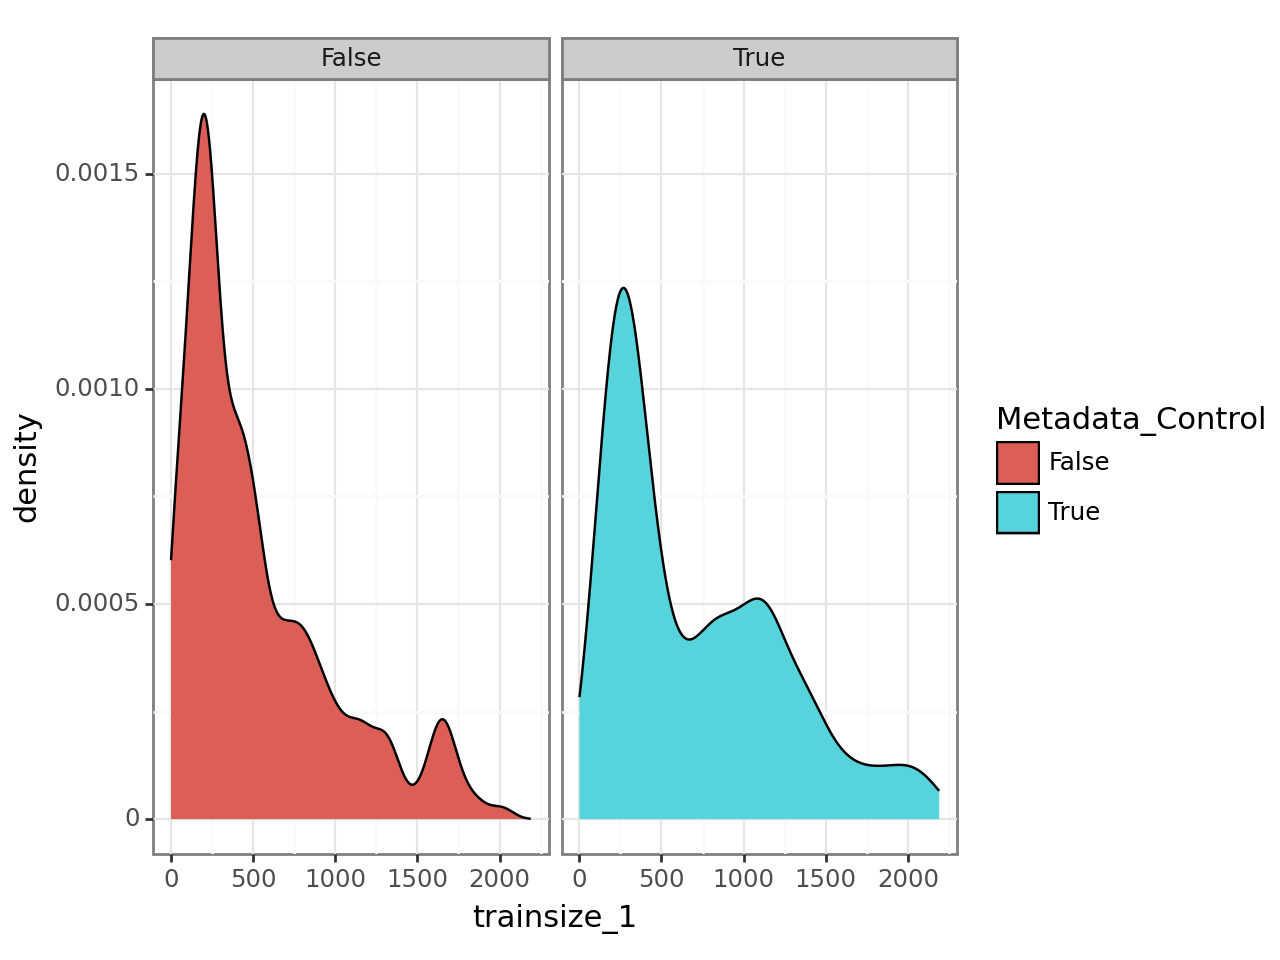

In [ ]:
# Here we see that the distribution of training cell count is quite comparable between the WT-VAR and CTRL-CTRL pairs

from plotnine import ggplot, aes, facet_wrap, theme_bw, geom_density

plot1 = (ggplot(metrics_df.filter(pl.col("Classifier_type") == "localization"), aes(x="trainsize_0", fill="Metadata_Control"))
 + geom_density()
 + facet_wrap("Metadata_Control")
 + theme_bw())
print(plot1)

plot2 = (ggplot(metrics_df.filter(pl.col("Classifier_type") == "localization"), aes(x="trainsize_1", fill="Metadata_Control"))
 + geom_density()
 + facet_wrap("Metadata_Control")
 + theme_bw())
print(plot2)

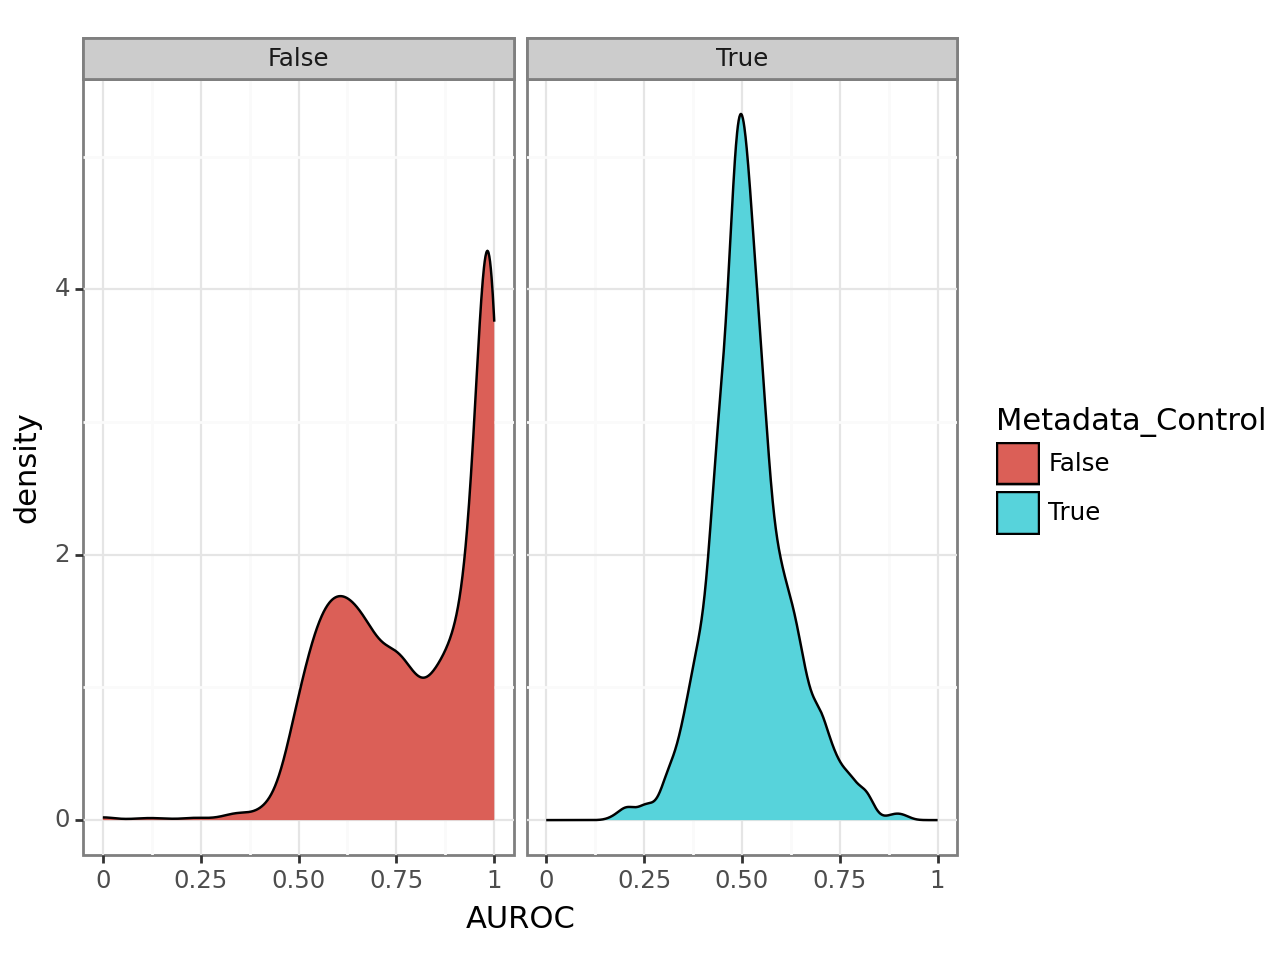

<Figure Size: (640 x 480)>

In [ ]:
from plotnine import ggplot, aes, facet_wrap, theme_bw, geom_density

(ggplot(metrics_df.filter(pl.col("Classifier_type") == "localization"), aes(x="AUROC", fill="Metadata_Control"))
 + geom_density()
 + facet_wrap("Metadata_Control")
 + theme_bw())

In [6]:
imbalance_thresh = 5

print(metrics_df.shape)
print(metrics_df.filter(pl.col("Training_imbalance") < imbalance_thresh).shape)

print(len(metrics_df.select("allele_0").to_series().unique().to_list()))
print(len(metrics_df.filter(pl.col("Training_imbalance") < imbalance_thresh).select("allele_0").to_series().unique().to_list()))

(15624, 23)
(14216, 23)
870
803


Next, look at metrics across replicates within each batch, and also across batches (compare metrics aggregated across replicates). 

In [7]:
metrics_df = metrics_df.with_columns(
    pl.when(pl.col("Full_Classifier_ID").str.contains("true"))
    .then(pl.lit("localization"))
    .otherwise(pl.lit("morphology")).alias("Classifier_type"),
    pl.when(pl.col("Full_Classifier_ID").str.contains("B7A"))
    .then(pl.lit("batch7"))
    .otherwise(pl.lit("batch8")).alias("Batch"),
    pl.col("Plate").str.slice(13, 7).str.replace("R.*_", "").alias("Allele_set")
)


In [8]:

metrics_summary = metrics_df.select([
 'AUROC',
 'AUPRC',
 'AUBPRC',
 'Macro_F1',
 'Balanced_Accuracy',
 'Classifier_type',
 'Metadata_Control',
 'allele_0',
 'Batch',
 'Allele_set'
]).group_by([ 'Classifier_type','Metadata_Control','allele_0','Batch', "Allele_set"]).agg([
    pl.all().exclude(['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch', 'Allele_set']).mean().suffix('_mean'),
    pl.all().exclude(['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch', 'Allele_set']).median().suffix('_median')
]).with_columns(pl.col("Metadata_Control").cast(pl.String).alias("Metadata_Control"))


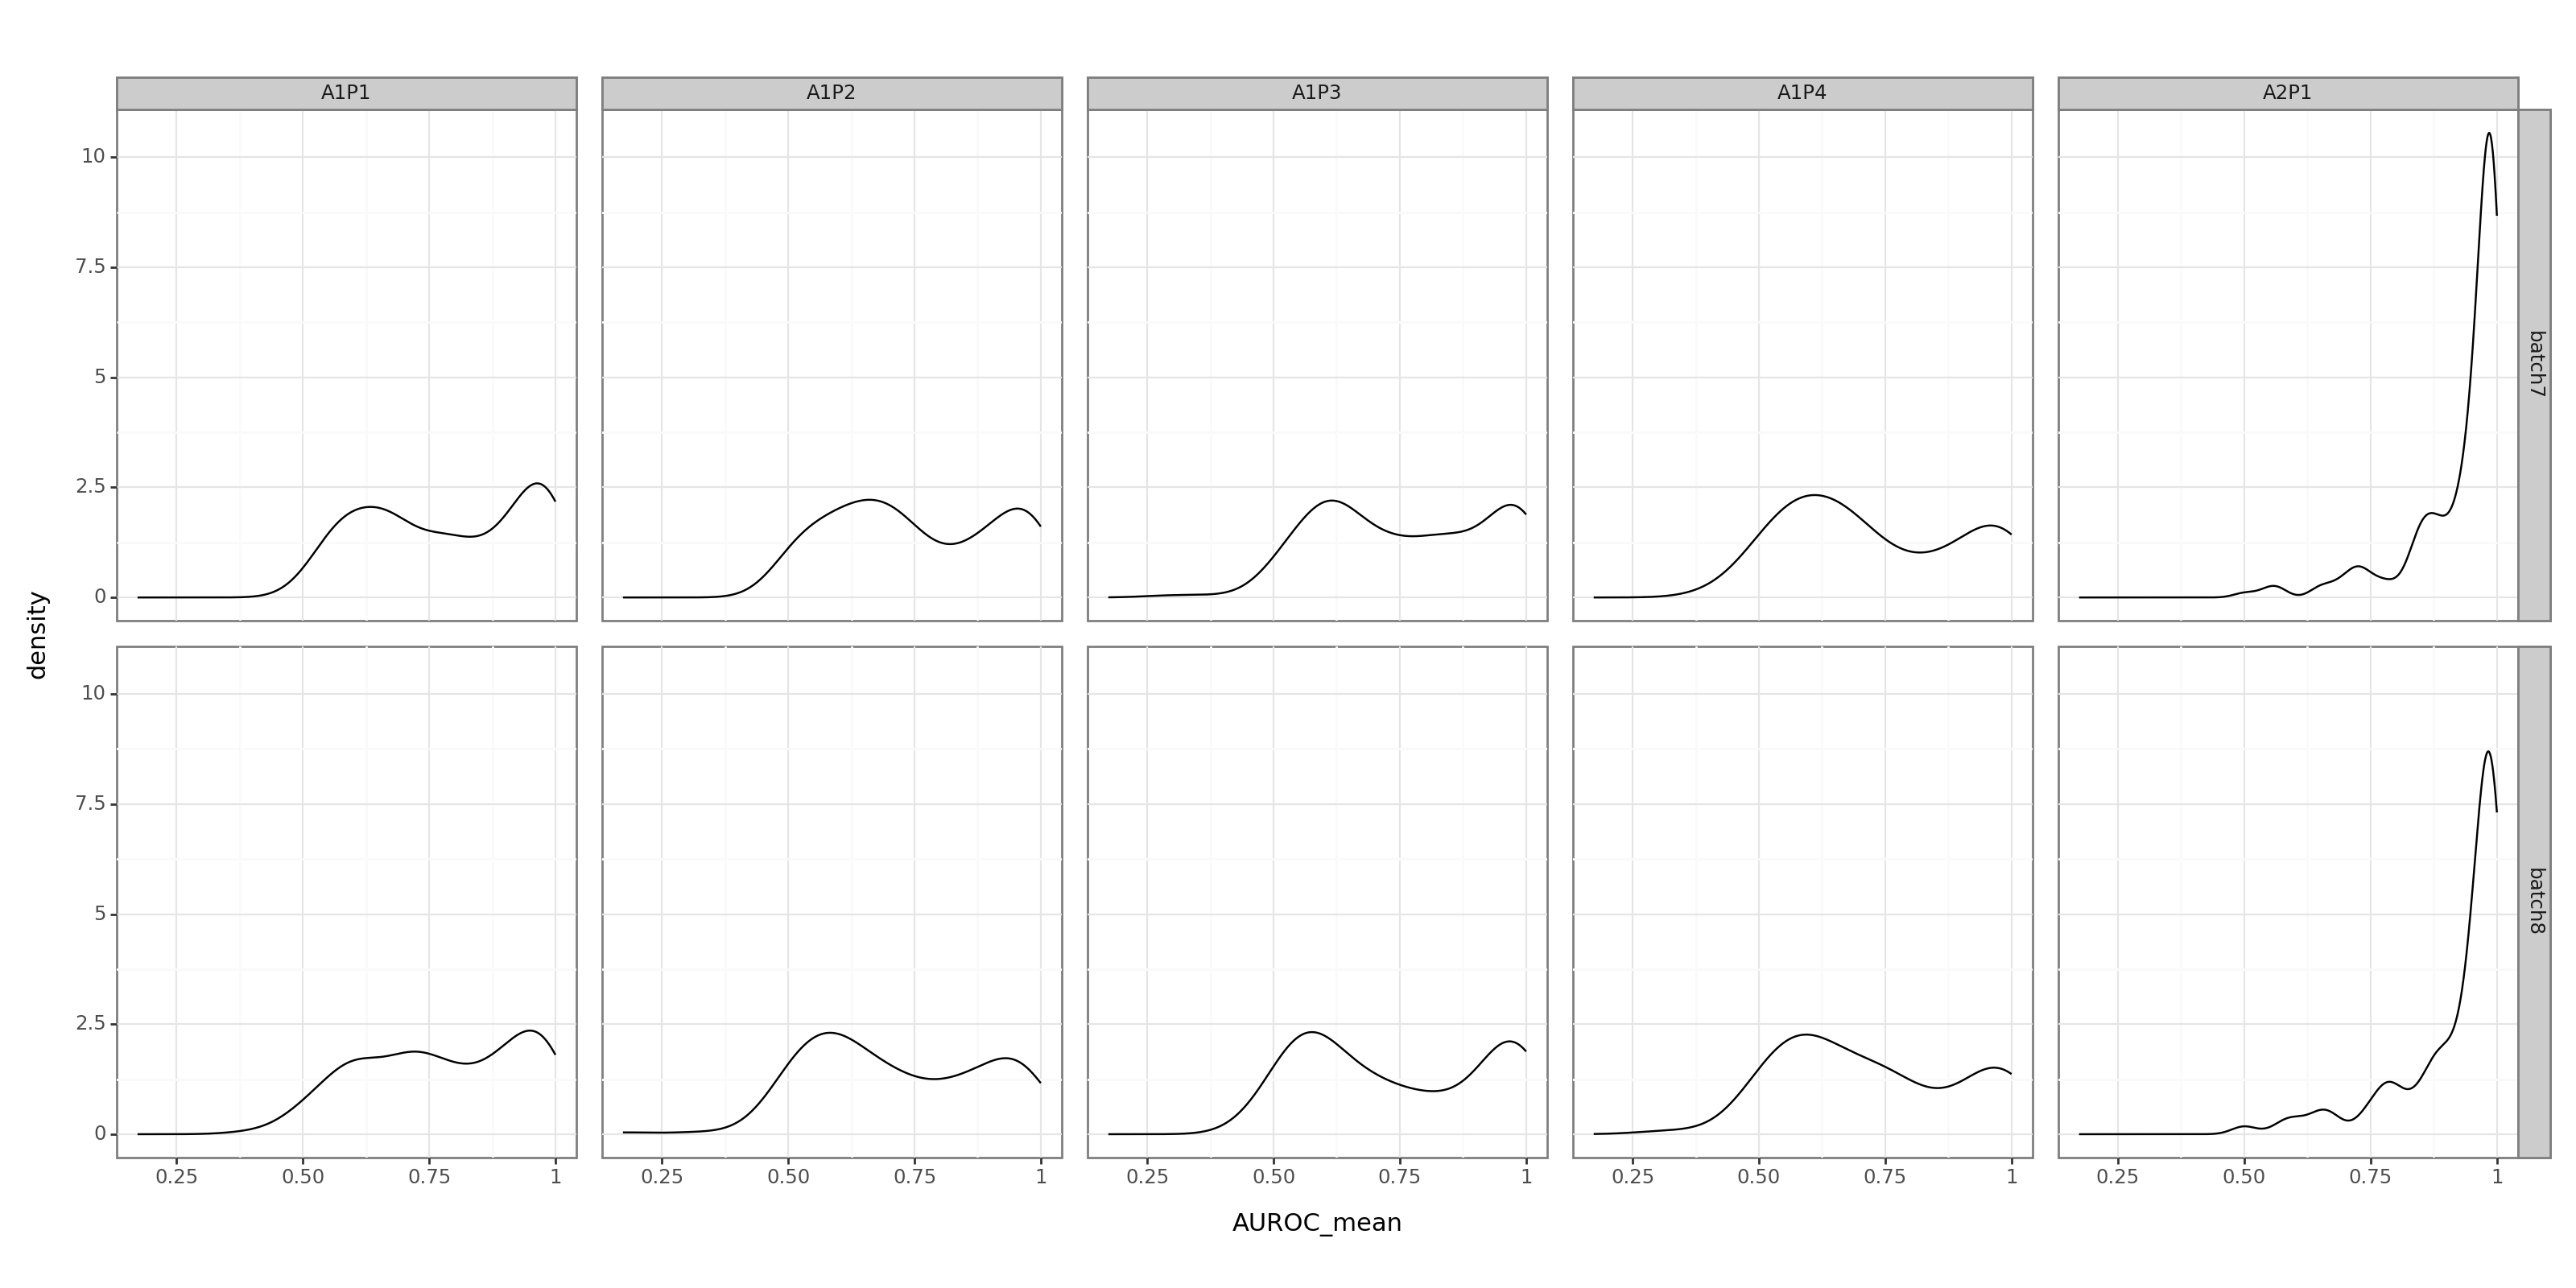

In [ ]:
# Compare across allele sets
from plotnine import geom_point, facet_grid, theme_bw, ggplot, aes, xlab

plotnine.options.figure_size = (16, 8)
plot1 = (ggplot(metrics_summary.filter((pl.col("Metadata_Control") == "false") & (pl.col("Classifier_type") == "localization")), aes(x="AUROC_mean"))
 + geom_density()
 + theme_bw()
 + facet_grid("Batch ~ Allele_set"))
print(plot1)

In [ ]:
# one plate looks wrong
a2p1 = metrics_summary.filter((pl.col("Allele_set") == "A1P4")
                              & (pl.col("Classifier_type") == "localization")
                              & (pl.col("Metadata_Control") == "false")).sort(pl.col("AUROC_mean"), descending=True)

print(a2p1.shape)
print(a2p1.filter(pl.col("AUROC_mean") > 0.81).shape)

(166, 15)
(55, 15)


In [9]:
# pivot to have separate column for batch 7 and batch 8
metrics_summary = metrics_summary.melt(id_vars=['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch', 'Allele_set'],
                                        value_vars=[col for col in metrics_summary.columns if col not in ['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch', 'Allele_set']],
                                        value_name="Value",
                                        variable_name="Metric").pivot(
                                            index=['Classifier_type', 'Metadata_Control', 'allele_0', 'Metric', 'Allele_set'], 
                                            columns='Batch',
                                            values='Value')

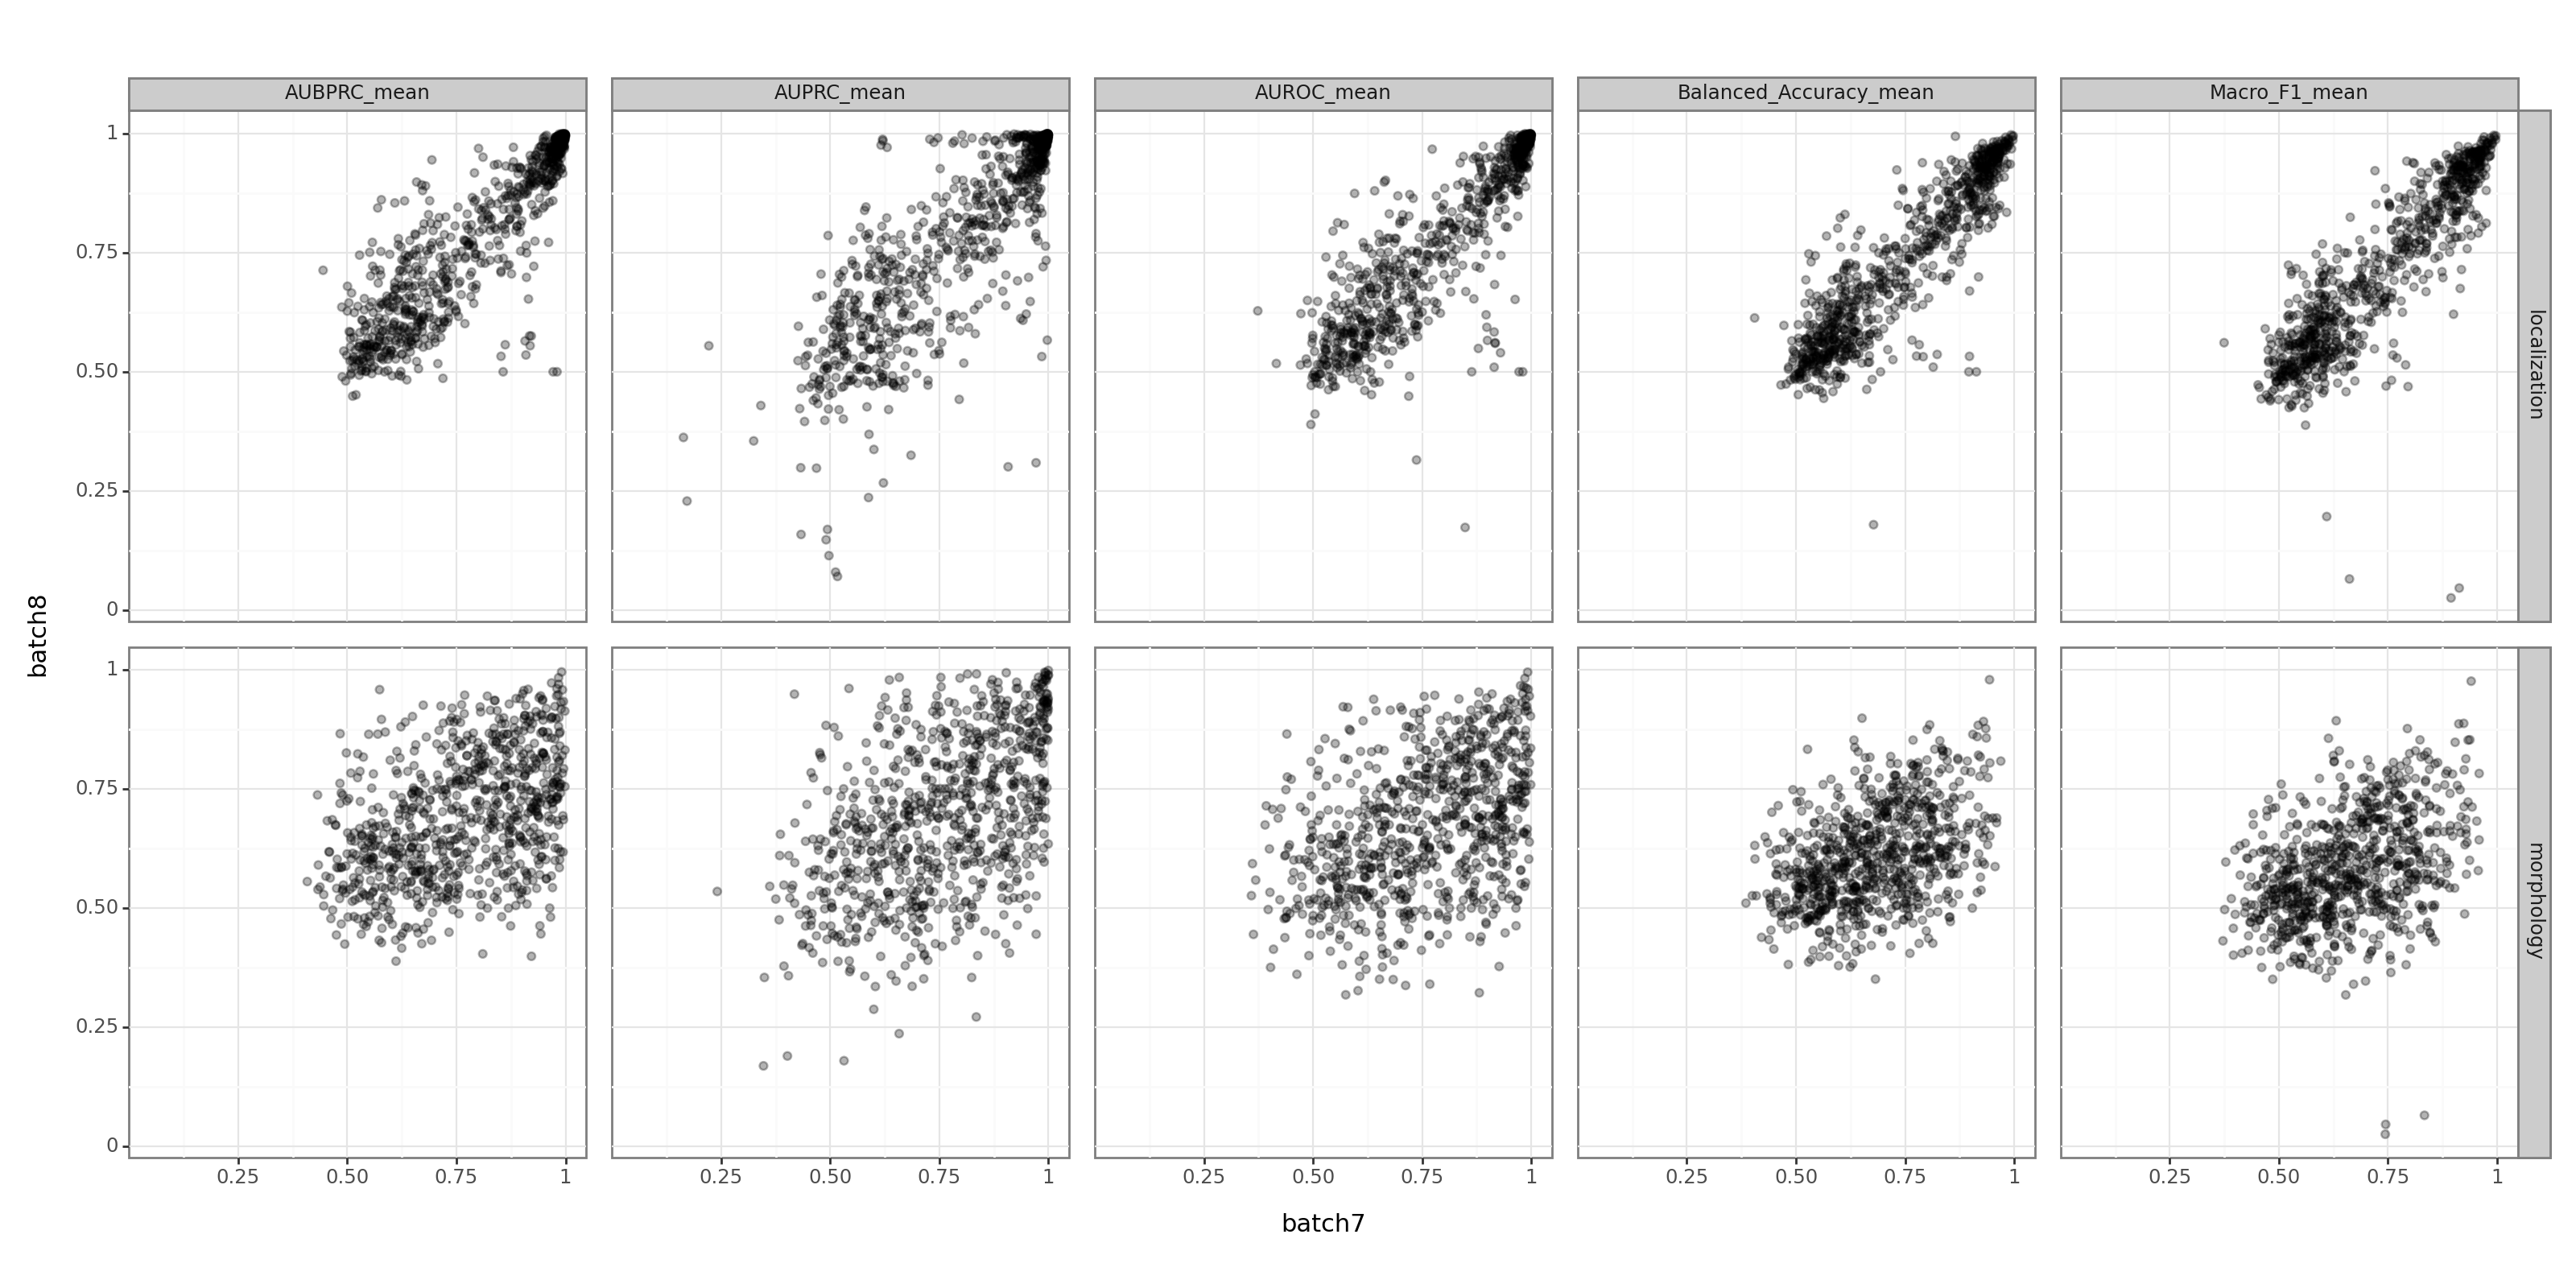

<Figure Size: (1600 x 800)>

In [ ]:
plotnine.options.figure_size = (16, 8)
(ggplot(metrics_summary.filter(pl.col("Metric").str.contains("mean")), aes(x="batch7", y="batch8"))
 + geom_point(alpha=0.3)
 + theme_bw()
 + facet_grid("Classifier_type ~ Metric", "free"))

In [10]:
# try after filtering based on imbalance
imbalance_thresh = 5
metrics_summary = metrics_df.filter(pl.col("Training_imbalance") < imbalance_thresh).select([
 'AUROC',
 'AUPRC',
 'AUBPRC',
 'Macro_F1',
 'Balanced_Accuracy',
 'Classifier_type',
 'Metadata_Control',
 'allele_0',
 'Batch',
 'Allele_set'
]).group_by([ 'Classifier_type','Metadata_Control','allele_0','Batch', "Allele_set"]).agg([
    pl.all().exclude(['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch', 'Allele_set']).mean().suffix('_mean'),
    pl.all().exclude(['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch', 'Allele_set']).median().suffix('_median')
]).with_columns(pl.col("Metadata_Control").cast(pl.String).alias("Metadata_Control"))

metrics_summary = metrics_summary.melt(id_vars=['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch', 'Allele_set'],
                                        value_vars=[col for col in metrics_summary.columns if col not in ['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch', 'Allele_set']],
                                        value_name="Value",
                                        variable_name="Metric").pivot(
                                            index=['Classifier_type', 'Metadata_Control', 'allele_0', 'Metric', 'Allele_set'],  # Preserving these columns as indexes
                                            columns='Batch',
                                            values='Value')


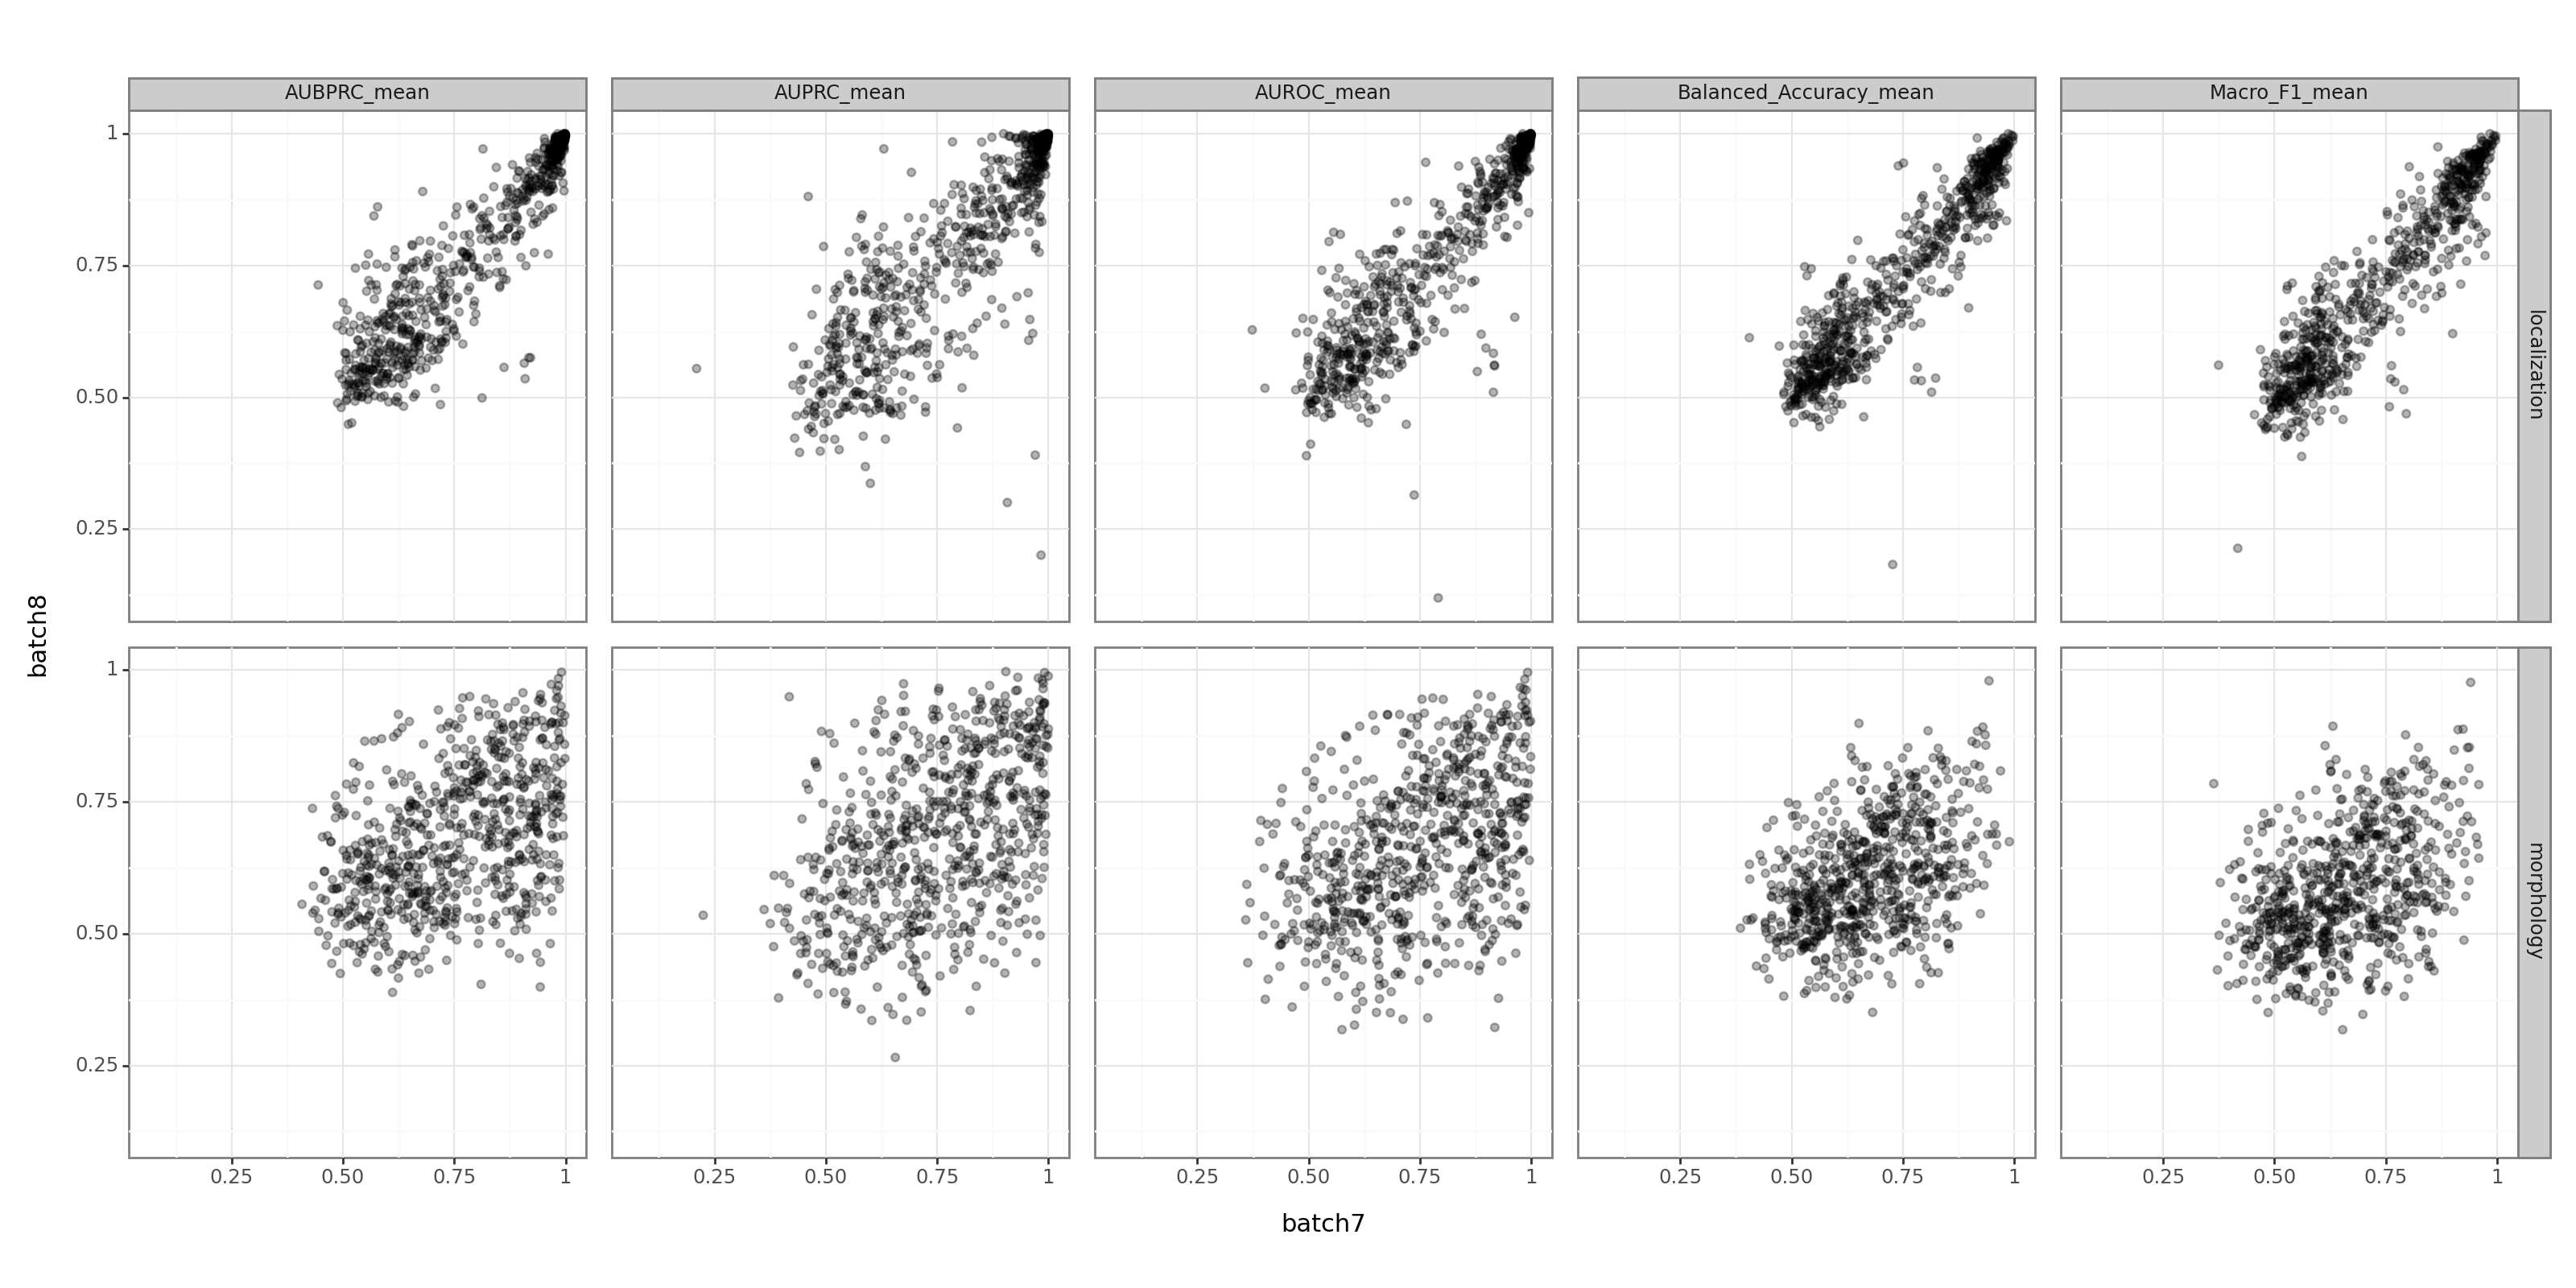

<Figure Size: (1600 x 800)>

In [ ]:
plotnine.options.figure_size = (16, 8)
(ggplot(metrics_summary.filter(pl.col("Metric").str.contains("mean")), aes(x="batch7", y="batch8"))
 + geom_point(alpha=0.3)
 + theme_bw()
 + facet_grid("Classifier_type ~ Metric", "free"))

Macro-averaged F1 score has the highest consistency across batches. Filtering to exclude classifiers with imbalanced classes prior to computing the batch-aggregated metrics improves consistency across batches. 

Even for macro-averaged F1 scores, there are a small number of classifiers with very inconsistent metrics across batch. Should we filter these out because they do not replicate? And then take the mean across batches?

In [11]:
# since classifier metrics were quite correlated across batch 7 and 8, compute summary metrics as the mean across all plates/batches
metrics_df = pl.read_csv(f"{metrics_dir}/metrics.csv")
metrics_df = metrics_df.with_columns(
    pl.col("Plate").str.slice(13, 7).str.replace("R.*_", "").alias("Allele_set")
)
thresh = 5

metrics_df = metrics_df.with_columns(
    pl.when(pl.col("Full_Classifier_ID").str.contains("true"))
    .then(pl.lit("localization"))
    .otherwise(pl.lit("morphology")).alias("Classifier_type"),
    pl.when(pl.col("Full_Classifier_ID").str.contains("B7A"))
    .then(pl.lit("batch7"))
    .otherwise(pl.lit("batch8")).alias("Batch"),
)

metrics_ctrl = metrics_df.filter(
    (pl.col("Training_imbalance") < thresh)
    & (pl.col("Metadata_Control") == True)
).select(["Classifier_type", "AUROC"]).group_by("Classifier_type").quantile(0.99)

print(metrics_ctrl)

metrics_wtvar = metrics_df.filter(
    (pl.col("Training_imbalance") < thresh)
    & (pl.col("Metadata_Control") == False)
    ).select([
 'AUROC',
 'AUPRC',
 'AUBPRC',
 'Macro_F1',
 'Balanced_Accuracy',
 'Classifier_type',
 'allele_0',
 'trainsize_0',
 'testsize_0',
 'trainsize_1',
 'testsize_1',
 'Allele_set',
 'Training_imbalance'
]).group_by(['Classifier_type','allele_0', "Allele_set"]).agg([
    pl.all().exclude(['Classifier_type', 'allele_0', "Allele_set"]).mean().suffix('_mean')
])
metrics_wtvar.write_csv(f"{metrics_dir}/metrics_summary.csv")

shape: (2, 2)
┌─────────────────┬──────────┐
│ Classifier_type ┆ AUROC    │
│ ---             ┆ ---      │
│ str             ┆ f64      │
╞═════════════════╪══════════╡
│ localization    ┆ 0.805732 │
│ morphology      ┆ 0.999333 │
└─────────────────┴──────────┘


In [37]:
# split into morphology and localization, and count the proportion of classifiers that surpass the 0.99 NULL F1 score
morph_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "morphology")
local_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "localization")

print(morph_wtvar.filter(pl.col("AUROC_mean") > 0.999).shape[0]/morph_wtvar.shape[0])
print(local_wtvar.filter(pl.col("AUROC_mean") > 0.81).shape[0]/local_wtvar.shape[0])

# Analyze AUROC wrt imbalance
local_wtvar_filt = local_wtvar.filter(pl.col("Allele_set") != "A2P1")
print(local_wtvar_filt.filter(pl.col("AUROC_mean") > 0.81).shape[0]/local_wtvar_filt.shape[0])

# Analyze wrt clinvar annotations
clinvar = pl.read_csv(f"../data/allele_collection_clinical_significance.csv")
clinvar = clinvar.with_columns(
    pl.concat_str(["symbol", "aa_change"], separator="_").alias("allele_0")
)

local_wtvar_filt = local_wtvar_filt.join(clinvar.select(["allele_0", "clinvar_cs"]), on="allele_0")
local_wtvar = local_wtvar.join(clinvar.select(["allele_0", "clinvar_cs"]), on="allele_0")

0.001256281407035176
0.47738693467336685
0.3729903536977492


In [38]:
# count %  mislocalized by label type
benign_local = local_wtvar_filt.filter(pl.col("clinvar_cs") == "Benign")
vus_local = local_wtvar_filt.filter(pl.col("clinvar_cs") == "VUS")
path_local = local_wtvar_filt.filter(pl.col("clinvar_cs") == "Pathogenic")

print("Benign")
print(benign_local.filter(pl.col("AUROC_mean") > 0.81).shape[0]/benign_local.shape[0])
print("# misloc: " + str(benign_local.filter(pl.col("AUROC_mean") > 0.81).shape[0]))
print("total #: " + str(benign_local.shape[0]))
print("\n")

print("VUS")
print(vus_local.filter(pl.col("AUROC_mean") > 0.81).shape[0]/vus_local.shape[0])
print("# misloc: " + str(vus_local.filter(pl.col("AUROC_mean") > 0.81).shape[0]))
print("total #: " + str(vus_local.shape[0]))
print("\n")

print("Pathogenic")
print(path_local.filter(pl.col("AUROC_mean") > 0.81).shape[0]/path_local.shape[0])
print("# misloc: " + str(path_local.filter(pl.col("AUROC_mean") > 0.81).shape[0]))
print("total #: " + str(path_local.shape[0]))

Benign
0.2823529411764706
# misloc: 24
total #: 85


VUS
0.36082474226804123
# misloc: 35
total #: 97


Pathogenic
0.4107883817427386
# misloc: 99
total #: 241


In [41]:
auroc_thresh = 0.98

print("Benign")
print(benign_local.filter(pl.col("AUROC_mean") > auroc_thresh).shape[0]/benign_local.shape[0])
print("# misloc: " + str(benign_local.filter(pl.col("AUROC_mean") > auroc_thresh).shape[0]))
print("total #: " + str(benign_local.shape[0]))
print("\n")

print("VUS")
print(vus_local.filter(pl.col("AUROC_mean") > auroc_thresh).shape[0]/vus_local.shape[0])
print("# misloc: " + str(vus_local.filter(pl.col("AUROC_mean") > auroc_thresh).shape[0]))
print("total #: " + str(vus_local.shape[0]))
print("\n")

print("Pathogenic")
print(path_local.filter(pl.col("AUROC_mean") > auroc_thresh).shape[0]/path_local.shape[0])
print("# misloc: " + str(path_local.filter(pl.col("AUROC_mean") > auroc_thresh).shape[0]))
print("total #: " + str(path_local.shape[0]))

Benign
0.11764705882352941
# misloc: 10
total #: 85


VUS
0.10309278350515463
# misloc: 10
total #: 97


Pathogenic
0.12448132780082988
# misloc: 30
total #: 241


In [43]:
benign_local.filter(pl.col("AUROC_mean") > auroc_thresh)

shape: (10, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Classifie ┆ allele_0  ┆ Allele_se ┆ AUROC_mea ┆ … ┆ trainsize ┆ testsize_ ┆ Training_ ┆ clinvar_ │
│ r_type    ┆ ---       ┆ t         ┆ n         ┆   ┆ _1_mean   ┆ 1_mean    ┆ imbalance ┆ cs       │
│ ---       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ _mean     ┆ ---      │
│ str       ┆           ┆ str       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ ---       ┆ str      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ localizat ┆ ACSF3_Ile ┆ A1P1      ┆ 0.980403  ┆ … ┆ 747.75    ┆ 249.25    ┆ 1.655334  ┆ Benign   │
│ ion       ┆ 200Met    ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ localizat ┆ XRCC2_Phe ┆ A1P4      ┆ 0.985152  ┆ … ┆ 984.75    ┆ 328.25    ┆ 1.307267  ┆ Benign   │
│ ion       ┆ 270Val    ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ localizat ┆ KRT8_Tyr5 ┆ A1P2      ┆ 0.986141  ┆ … ┆ 598.5     ┆ 199.5     ┆ 1.6129    ┆ Benign   │
│ ion       ┆ 4His      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ localizat ┆ BAG3_Arg2 ┆ A1P1      ┆ 0.999221  ┆ … ┆ 411.33333 ┆ 161.66666 ┆ 3.624123  ┆ Benign   │
│ ion       ┆ 58Trp     ┆           ┆           ┆   ┆ 3         ┆ 7         ┆           ┆          │
│ localizat ┆ UNC119_Gl ┆ A1P4      ┆ 0.993609  ┆ … ┆ 319.125   ┆ 106.375   ┆ 1.611365  ┆ Benign   │
│ ion       ┆ y22Val    ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ localizat ┆ CRADD_Arg ┆ A1P1      ┆ 0.997679  ┆ … ┆ 516.75    ┆ 172.25    ┆ 1.541757  ┆ Benign   │
│ ion       ┆ 185Gln    ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ localizat ┆ TTR_Gly26 ┆ A1P4      ┆ 0.981532  ┆ … ┆ 909.75    ┆ 303.25    ┆ 2.61163   ┆ Benign   │
│ ion       ┆ Ser       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ localizat ┆ RASA1_Glu ┆ A1P3      ┆ 0.984503  ┆ … ┆ 573.42857 ┆ 204.28571 ┆ 1.579643  ┆ Benign   │
│ ion       ┆ 70Gly     ┆           ┆           ┆   ┆ 1         ┆ 4         ┆           ┆          │
│ localizat ┆ NT5C3A_Ph ┆ A1P3      ┆ 0.994342  ┆ … ┆ 812.57142 ┆ 290.57142 ┆ 1.145956  ┆ Benign   │
│ ion       ┆ e31Leu    ┆           ┆           ┆   ┆ 9         ┆ 9         ┆           ┆          │
│ localizat ┆ COQ8A_His ┆ A1P1      ┆ 0.992837  ┆ … ┆ 243.375   ┆ 81.125    ┆ 2.544305  ┆ Benign   │
│ ion       ┆ 80Tyr     ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

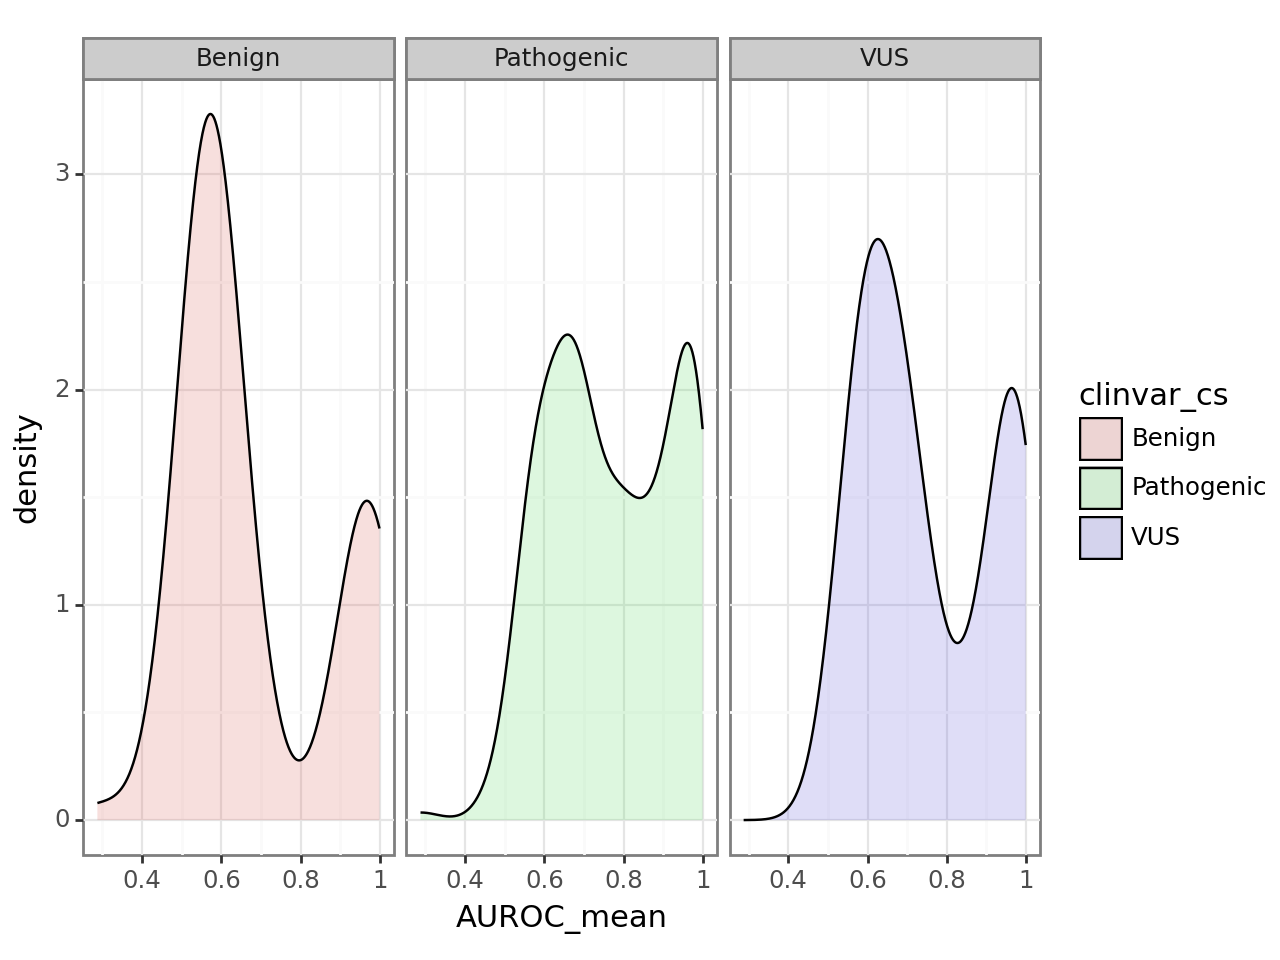

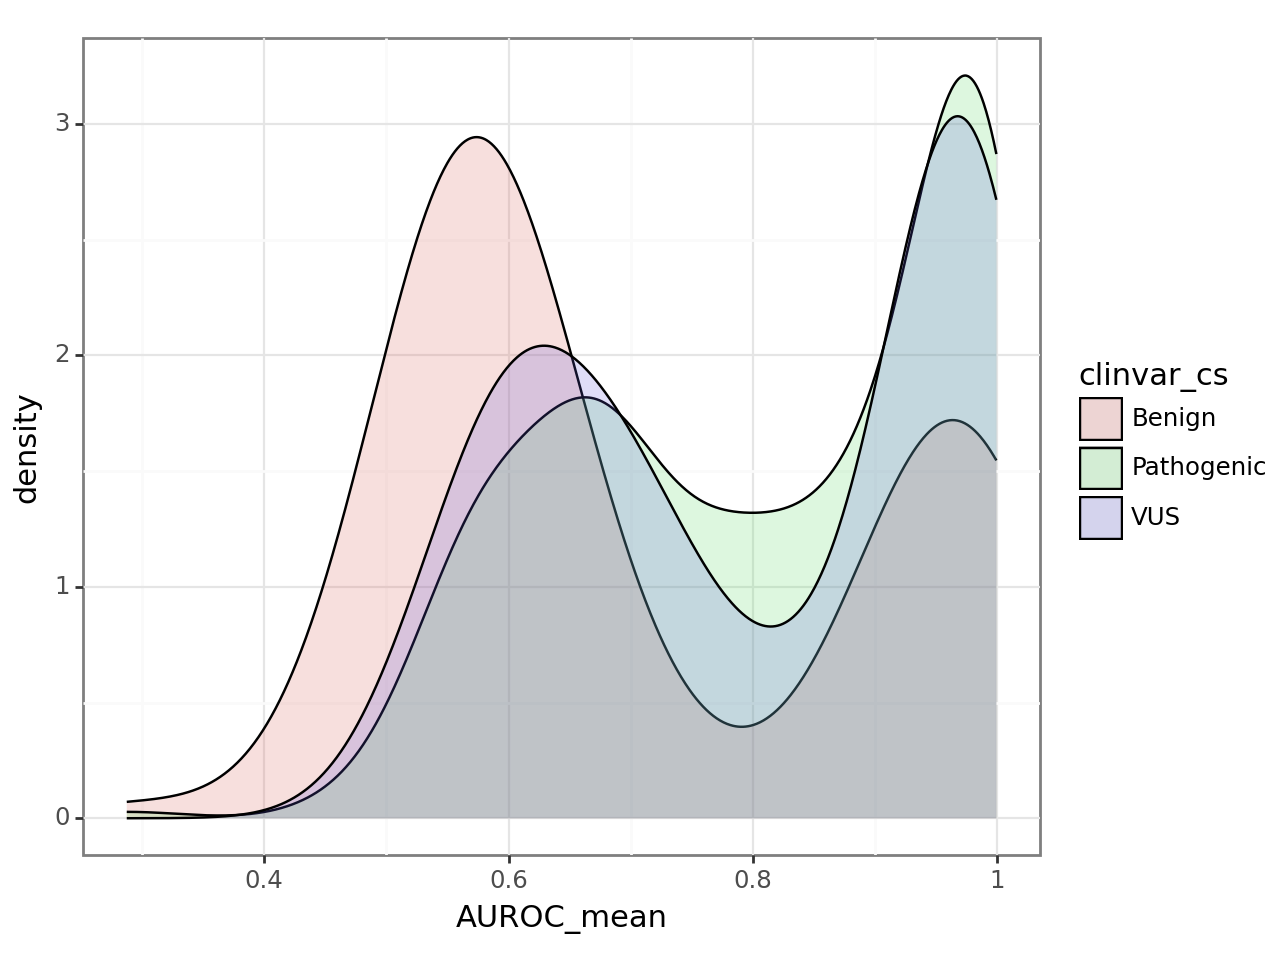

In [23]:
from plotnine import ggplot, aes, facet_wrap, theme_bw, geom_density

plot1 = (ggplot(local_wtvar_filt.filter(pl.col("clinvar_cs").is_in(["Benign", "Pathogenic", "VUS"])), aes(x="AUROC_mean", fill="clinvar_cs"))
 + geom_density(alpha=0.2)
 + facet_wrap("clinvar_cs")
 + theme_bw())
print(plot1)

plot2 = (ggplot(local_wtvar.filter(pl.col("clinvar_cs").is_in(["Benign", "Pathogenic", "VUS"])), aes(x="AUROC_mean", fill="clinvar_cs"))
 + geom_density(alpha=0.2)
 + theme_bw())
print(plot2)

In [18]:
local_wtvar_benign = local_wtvar_filt.filter(pl.col("clinvar_cs") == "Benign").sort(pl.col("AUROC_mean"), descending=True)

## Look at abundance annotations

In [45]:
abun = pl.read_csv("../data/abundance_ppi_his3_edgotyping.tsv", separator="\t")
abun = abun.filter(pl.col("aa_change") != "WT").with_columns(
    pl.concat_str(["symbol", "aa_change"], separator="_").alias("allele_0")
)
local_wtvar_filt = local_wtvar_filt.join(abun.select("allele_0", "z_abundance_change"), on="allele_0")
local_wtvar_filt = local_wtvar_filt.with_columns(
    pl.col("z_abundance_change").cast(pl.Float32()).alias("z_abundance_change")
)
local_wtvar_filt = local_wtvar_filt.with_columns(
    pl.col("z_abundance_change").abs().alias("z_abundance_change_abs")
)

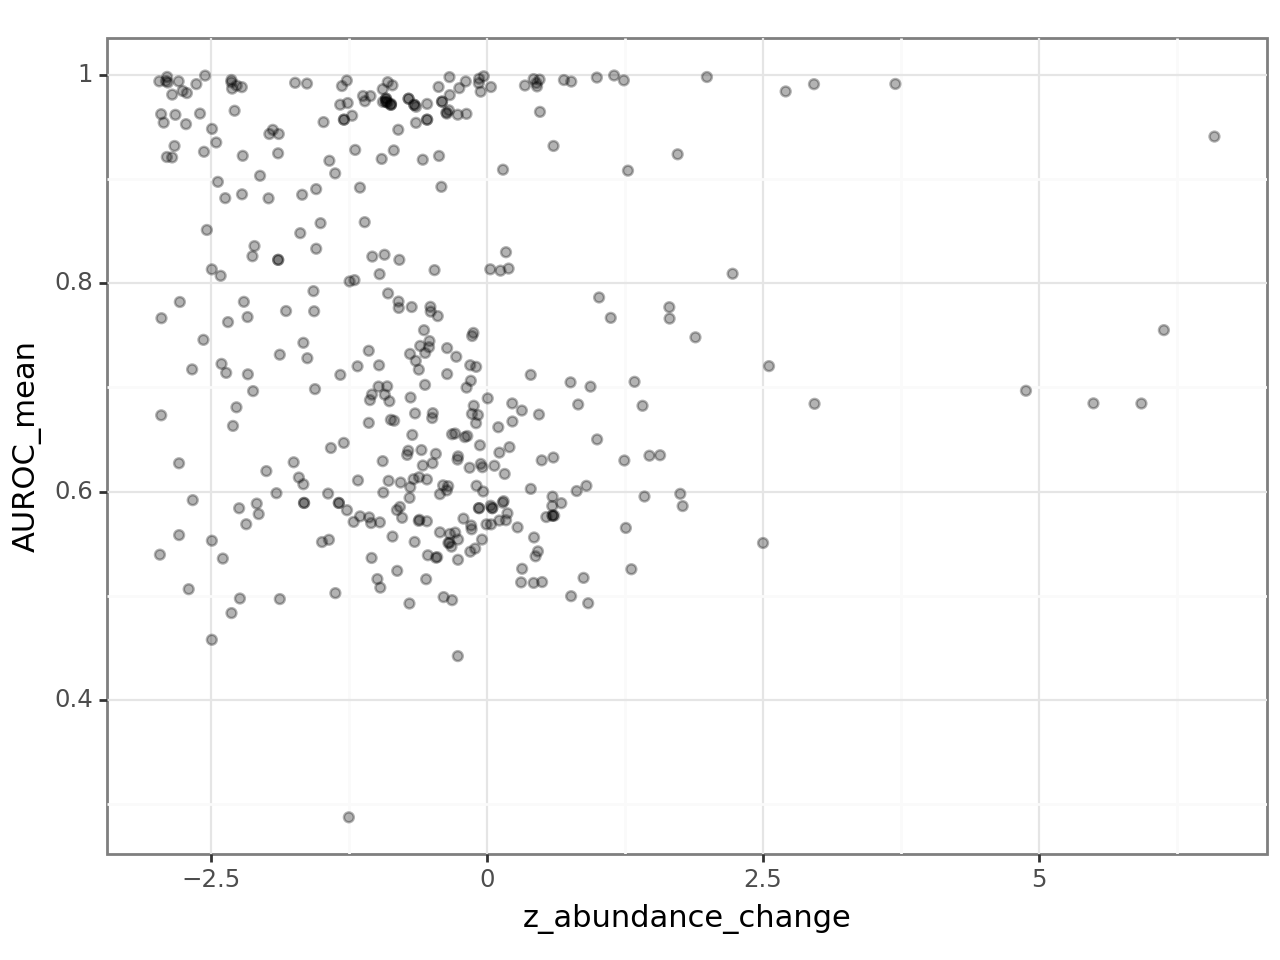

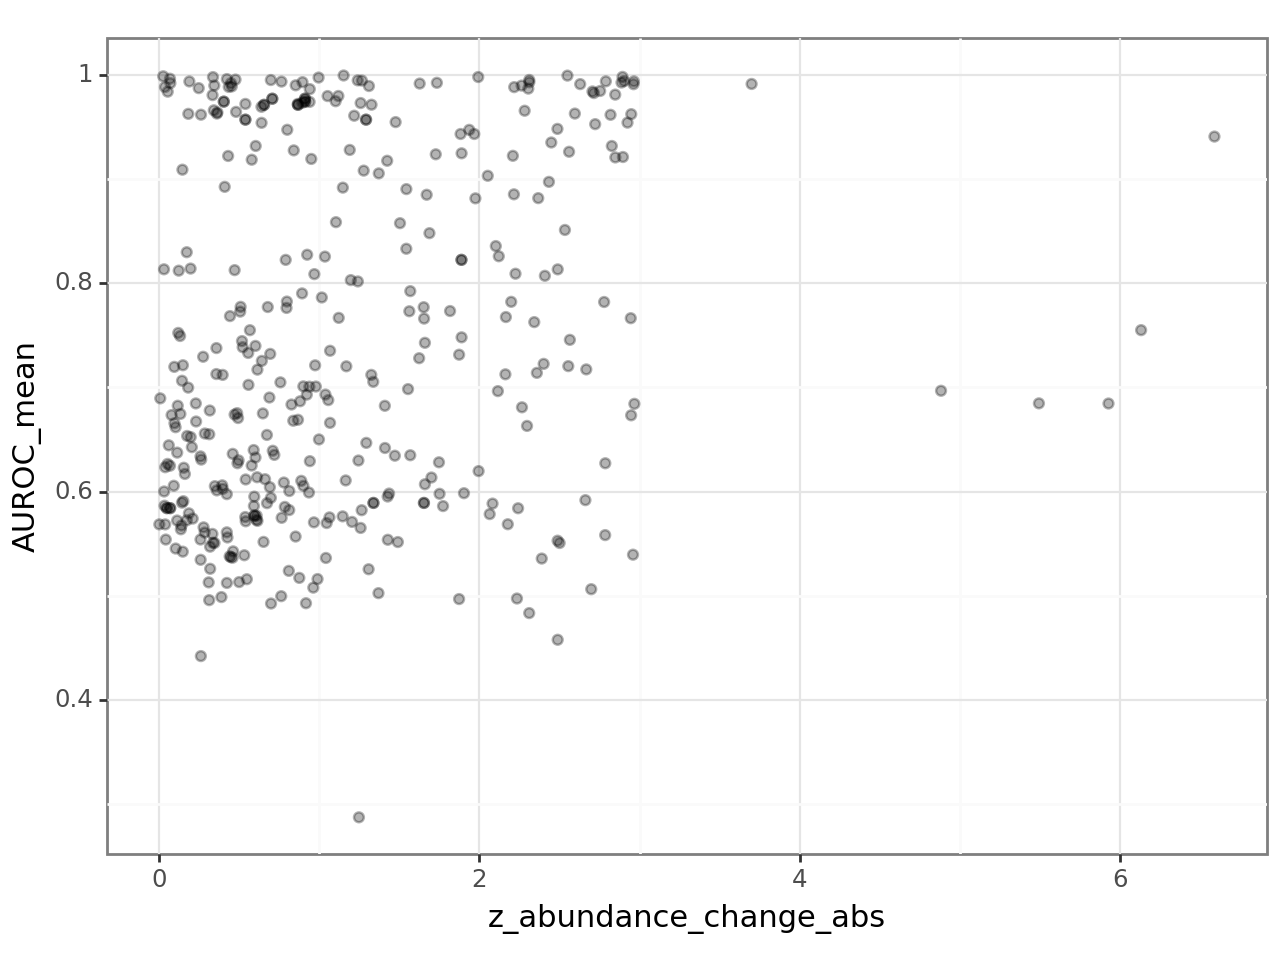

In [46]:
from plotnine import ggplot, aes, facet_wrap, theme_bw, geom_point

plot1 = (ggplot(local_wtvar_filt.filter(pl.col("z_abundance_change").is_not_null()), aes(y="AUROC_mean", x="z_abundance_change"))
 + geom_point(alpha=0.3)
 + theme_bw())
print(plot1)

plot2 = (ggplot(local_wtvar_filt.filter(pl.col("z_abundance_change").is_not_null()), aes(y="AUROC_mean", x="z_abundance_change_abs"))
 + geom_point(alpha=0.3)
 + theme_bw())
print(plot2)

In [7]:
# concatenate all platemaps
pms = ["B7A1R1_P1.txt", "B7A1R1_P2.txt", "B7A1R1_P3.txt", "B7A1R1_P4.txt", "B7A2R1_P1.txt", "B8A1R2_P1.txt", "B8A1R2_P2.txt", "B8A1R2_P3.txt", "B8A1R2_P4.txt", "B8A2R2_P1.txt"]

pm_dfs = []
for pm in pms:
    try:
        temp = pl.read_csv(f"{pm_dir}/{pm}", separator="\t").select(['plate_map_name', 'well_position', 'control_type', 'gene_allele'])
        pm_dfs.append(temp)
    except Exception as e:
        print("Error reading {pm}: {e}")
    
pm_df = pl.concat(pm_dfs).rename({"well_position": "Well", "plate_map_name": "Plate", "gene_allele": "Allele"}).with_columns(
    pl.lit("05").alias("Site"),
    pl.col("Plate").str.slice(0,6).alias("Batch")
)

rep_df = pl.DataFrame({
    "Batch": ["B7A1R1", "B7A1R1", "B7A1R1", "B7A1R1", 
              "B7A2R1", "B7A2R1", "B7A2R1", "B7A2R1", 
              "B8A1R2", "B8A1R2", "B8A1R2", "B8A1R2",
              "B8A2R2", "B8A2R2", "B8A2R2", "B8A2R2"],
    "Replicate": ["T1", "T2", "T3", "T4",
                  "T1", "T2", "T3", "T4",
                  "T1", "T2", "T3", "T4",
                  "T1", "T2", "T3", "T4"]
})

pm_df = pm_df.join(rep_df, on="Batch")


In [37]:
# Summarize results by allele
local_gene = local_wtvar.join(pm_df.filter(pl.col("control_type") == "allele").select(["Allele", "Site"]).unique().rename({"Allele": "allele_0"}), on="allele_0", how="outer").select([
    "allele_0_right", "AUROC_mean"
])

local_gene = local_gene.with_columns(
    pl.col("allele_0_right").str.replace("_.*", "").alias("Gene")
).group_by("Gene").agg([
    pl.count().alias("Number_variants"),
    pl.col("AUROC_mean").mean().alias("Mean_AUROC_all_variants"),
    pl.col("AUROC_mean").is_null().sum().alias("Null_classifier")
]).filter(pl.col("Gene").is_not_null())

local_gene.write_csv(f"{metrics_dir}/metrics_gene_summary.csv")


## Plot images for each WT-VAR pair

In [9]:
local_wtvar = local_wtvar.sort(pl.col("AUROC_mean"), descending=True)

var_alleles = local_wtvar.select("allele_0").to_series().to_list()
auroc = local_wtvar.select("AUROC_mean").to_series().to_list()

plot_dir = "/dgx1nas1/storage/data/jess/varchamp/images/B7B8_1percent_wtvar_v2"


In [32]:
allele_nms = []
root_nms = []
old_nms = os.listdir(plot_dir)
for nm in old_nms:
    nm_list = nm.split("_")
    root_nms.append("_".join(nm_list[1:4]))
    allele_nms.append("_".join(nm_list[1:3]))
    
nm_df = pl.DataFrame({
    "allele_0": allele_nms,
    "old_nm": old_nms,
    "new_root": root_nms
})
nm_df = nm_df.join(local_wtvar.select(["allele_0", "AUROC_mean"]), on="allele_0", how="left")
nm_df = nm_df.sort(pl.col("AUROC_mean"), descending=True)

In [33]:
counter = 0
for row in nm_df.to_dicts():
    old_nm = row['old_nm']
    
    if row['AUROC_mean']:
        padded_counter = str(counter).zfill(4)
        auroc_str = str(round(row['AUROC_mean'], 2)).replace(".", "_")
        new_nm = f"{str(padded_counter)}_{row['new_root']}_{auroc_str}.png"
        counter = counter + 1
    else:
        new_nm = f"ZZ_{row['new_root']}.png"
        
    os.rename(f"{plot_dir}/{old_nm}", f"{plot_dir}/{new_nm}")

In [79]:
# plot the 5th site from all images, organized by classifier
counter = 0
for var_allele in tqdm(var_alleles):
    padded_counter = str(counter).zfill(3)
    auroc_str = str(round(auroc[counter], 2)).replace(".", "_")
    
    gfp_nm = f"{str(padded_counter)}_{var_allele}_GFP_{auroc_str}.png"
    mito_nm = f"{str(padded_counter)}_{var_allele}_Mito_{auroc_str}.png"
    
    wt_allele = var_allele.split("_")[0]
    plot_img = pm_df.filter(((pl.col("Allele") == var_allele) | (pl.col("Allele") == wt_allele))).unique().sort(["Allele", "Batch", "Replicate"])
    
    # filter to keep only images where there is a single WT-VAR pair in each plate
    plates_img = plot_img.select(["Plate", "control_type"]).unique().select("Plate").to_series().to_list()
    plates_img = collections.Counter(plates_img)
    plates_img = pl.DataFrame(plates_img).melt().filter(pl.col("value") == 2).select("variable").to_series().to_list()
    plot_img = plot_img.filter(pl.col("Plate").is_in(plates_img))

    di.plotMultiImages(plot_img, "GFP", 0.99, 4, display=False, plotpath=f"{plot_dir}/{gfp_nm}")
    di.plotMultiImages(plot_img, "Mito", 0.99, 4, display=False, plotpath=f"{plot_dir}/{mito_nm}")
    counter = counter + 1

100%|██████████| 933/933 [14:53:29<00:00, 57.46s/it]  
